In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr,spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:

base_dir = '/Users/li/Desktop/debate/braindata'

sub_list = [f'sub-{x:0>3d}' for x in range(13,51)]
sub_list.remove('sub-021')

subs_roi_data = []
for sub in sub_list:
    csv_file = f'/Volumes/Li/task-debate/braindata/denoised 5/parcel data/Schaefer 200 combine 6 runs/{sub}_combined_time-series_Schaefer2018_200Parcels_7Networks.csv'
    sub_data = pd.read_csv(csv_file)
    subs_roi_data.append(sub_data.values)

all_brain_data = np.array(subs_roi_data)

mask_file = '/Users/li/Desktop/template/Schaefer/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz'
mask_img = nib.load(mask_file)
mask_data = mask_img.get_fdata()

nw_labels = pd.read_csv('/Users/li/Desktop/template/Schaefer/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
roi_name = list(nw_labels['ROI Name'])


In [7]:

sub_list = list(range(13,51))
sub_list.remove(21)

subs_change_tr = []
for sub in sub_list:
    # time points
    sub_time_file = f'/Users/li/Desktop/task-debate/behavdata/during_scan/combined_6runs_filter_diff/subject_{sub}_rate_diff.csv'
    df = pd.read_csv(sub_time_file)
    change_time = list(df['time'][1:])
    tr = [round(x/2) for x in change_time]
    subs_change_tr.append(tr)


brain_ISC_np = np.zeros((200, 37, 37))

for i in range(37):
    for j in range(i, 37): 
        
        if i == j:
            brain_ISC_np[:,i, j] = 0 #对角线元素设为1
            continue
        
        #计算两人变化点的并集
        sub_i_tr = subs_change_tr[i]
        sub_j_tr = subs_change_tr[j]
        combined = sub_i_tr + sub_j_tr

        # 删除两人并集变化点前后10个tr数据
        delete_tr = sorted({i for x in combined for i in range(x - 5, x + 11)})
        delete_tr = [item for item in delete_tr if item < 1493]
        delete_tr = [item for item in delete_tr if item > 1]

        # 删除
        sub_i_data = all_brain_data[i,:,:]
        sub_j_data = all_brain_data[j,:,:]
        sub_i_data = np.delete(sub_i_data, delete_tr, axis=0)
        sub_j_data = np.delete(sub_j_data, delete_tr, axis=0)

        # 现在，sub_data 是TR数*200的二维数组，计算每个roi的相关
        correlations = np.array([pearsonr(sub_i_data[:,i], sub_j_data[:,i])[0] for i in range(sub_i_data.shape[1])])
        
        brain_ISC_np[:, i, j] = correlations
        brain_ISC_np[:, j, i] = correlations

print("brain_ISC_np.shape", brain_ISC_np.shape)

brain_ISC_Z_np = np.arctanh(brain_ISC_np)

sns.heatmap(brain_ISC_np.mean(0))


brain_ISC_np.shape (200, 37, 37)


<Axes: >

In [8]:
brain_ISC_np_dis = brain_ISC_np

In [9]:
brain_correlation_matrices = []

for node in range(all_brain_data.shape[2]):
    brain_correlation_matrices.append(Adjacency(1 - pairwise_distances(all_brain_data[:, :, node], metric='correlation'), matrix_type='similarity'))
brain_ISC = Adjacency(brain_correlation_matrices)

brain_ISC_np = np.array(brain_ISC.squareform())
print(brain_ISC_np.shape)
brain_ISC_Z_np = np.arctanh(brain_ISC_np)
brain_ISC_np_nodis = brain_ISC_np

(200, 37, 37)


In [53]:
dACC_ISC_discard = brain_ISC_np_dis[89][np.triu_indices(37, k=1)]


dACC_ISC =  brain_ISC_np_nodis[89][np.triu_indices(37, k=1)]

# 计算差值
difference = np.abs(dACC_ISC_discard - dACC_ISC)

# 计算统计数据
mean_diff = np.mean(difference)
std_diff = np.std(difference)
median_diff = np.median(difference)

mean_diff, std_diff, median_diff

(0.018041797304933778, 0.016374203058650175, 0.01388321999273126)

In [47]:
from scipy import stats

# Perform a one-sample t-test to test if the mean of the difference is significantly different from 0
t_stat, p_value = stats.ttest_1samp(difference, 0)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: -4.676136806929058
P-value: 3.541385053037648e-06


In [51]:
from scipy.stats import ttest_rel

# 计算配对样本t检验
t_stat, p_value = ttest_rel(dACC_ISC_discard, dACC_ISC)

t_stat, p_value


(-4.676136806929058, 3.541385053037648e-06)

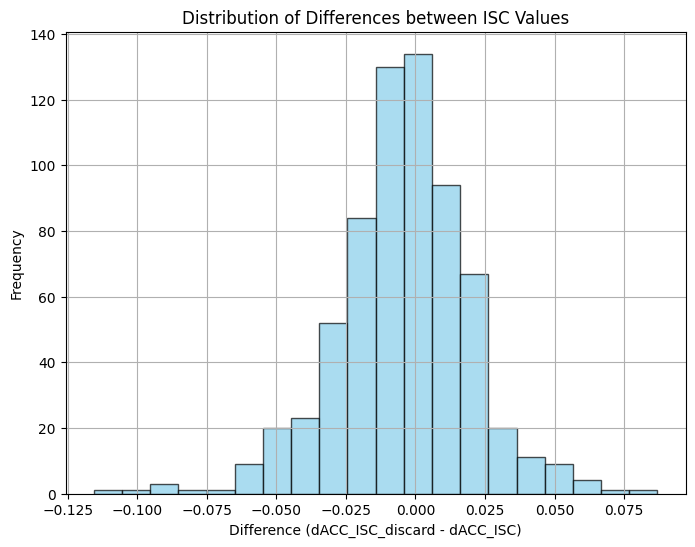

In [49]:
import matplotlib.pyplot as plt

# Plotting the distribution of the 'difference' values
plt.figure(figsize=(8, 6))
plt.hist(difference, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Differences between ISC Values')
plt.xlabel('Difference (dACC_ISC_discard - dACC_ISC)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [41]:
from scipy.stats import pearsonr, spearmanr

# Calculate the Pearson correlation between the two lists
corr_coefficient, p_value = pearsonr(dACC_ISC_discard, dACC_ISC)

print(f"Pearson correlation coefficient: {corr_coefficient}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.8317798815533066
P-value: 6.851709606774075e-172
